In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


DATA PREPARATION

In [ ]:
#### Splitting TB data into train, test, and validation sets ####

import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Paths to the image and mask directories
image_dir = "Data/TB/images"
mask_dir = "Data/TB/masks"

# Get and sort the filenames
image_filenames = sorted(os.listdir(image_dir))
mask_filenames = sorted(os.listdir(mask_dir))

# Ensure that the number of images and masks match
assert len(image_filenames) == len(mask_filenames), "Number of images and masks do not match!"

# Create a DataFrame with image and mask paths
data = pd.DataFrame({
    "image": [os.path.join(image_dir, f) for f in image_filenames],
    "mask": [os.path.join(mask_dir, f) for f in mask_filenames]
})

# Shuffle the data
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the data into train (70%), test (20%), and validation (10%)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
test_data, val_data = train_test_split(test_data, test_size=0.3333, random_state=42)  # 1/3 of test = 10% overall

# Print the sizes to verify
print(f"Train size: {len(train_data)}")
print(f"Test size: {len(test_data)}")
print(f"Validation size: {len(val_data)}")

# Save the splits to CSV files
train_data.to_csv("Data/TB/train.csv", index=False)
test_data.to_csv("Data/TB/test.csv", index=False)
val_data.to_csv("Data/TB/validation.csv", index=False)

print("CSV files created: train.csv, test.csv, validation.csv")


Train size: 1127
Test size: 188
Validation size: 94
CSV files created: train.csv, test.csv, validation.csv


In [ ]:
#### Splitting Other pathology than TB data into train, test, and validation sets ####

import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Path to the image directory
image_dir = "Data/Other_than_TB"

# Get and sort the filenames
image_filenames = sorted(os.listdir(image_dir))

# Create a DataFrame with image paths
data = pd.DataFrame({
    "image": [os.path.join(image_dir, f) for f in image_filenames]
})

# Shuffle the data
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the data into train (70%), test (20%), and validation (10%)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
test_data, val_data = train_test_split(test_data, test_size=0.3333, random_state=42)  # 1/3 of test = 10% overall

# Print the sizes to verify
print(f"Train size: {len(train_data)}")
print(f"Test size: {len(test_data)}")
print(f"Validation size: {len(val_data)}")

# Save the splits to CSV files
train_data.to_csv("Data/Other_than_TB/train.csv", index=False)
test_data.to_csv("Data/Other_than_TB/test.csv", index=False)
val_data.to_csv("Data/Other_than_TB/validation.csv", index=False)

print("CSV files created: train.csv, test.csv, validation.csv")

Train size: 1042
Test size: 174
Validation size: 87
CSV files created: train.csv, test.csv, validation.csv


In [ ]:
#### Splitting Healthy data into train, test, and validation sets ####

import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Path to the image directory
image_dir = "Data/Healthy"

# Get and sort the filenames
image_filenames = sorted(os.listdir(image_dir))

# Create a DataFrame with image paths
data = pd.DataFrame({
    "image": [os.path.join(image_dir, f) for f in image_filenames]
})

# Shuffle the data
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the data into train (70%), test (20%), and validation (10%)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
test_data, val_data = train_test_split(test_data, test_size=0.3333, random_state=42)  # 1/3 of test = 10% overall

# Print the sizes to verify
print(f"Train size: {len(train_data)}")
print(f"Test size: {len(test_data)}")
print(f"Validation size: {len(val_data)}")

# Save the splits to CSV files
train_data.to_csv("Data/Healthy/train.csv", index=False)
test_data.to_csv("Data/Healthy/test.csv", index=False)
val_data.to_csv("Data/Healthy/validation.csv", index=False)

print("CSV files created: train.csv, test.csv, validation.csv")

Train size: 1219
Test size: 203
Validation size: 102
CSV files created: train.csv, test.csv, validation.csv


MODEL TRAINING

In [ ]:
# Defining the BatchGenerator class

import numpy as np
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence
import random

class BatchGenerator(Sequence):
    def __init__(self, csv_path, batch_size=32, img_size=768, shuffle=True):
        self.csv_path = csv_path
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle

        # Load the CSV and extract image and mask paths
        self.data = pd.read_csv(csv_path)
        prefix = "/content/drive/MyDrive/A&S/Source code/"

        # Prepend the prefix to non-empty paths
        self.image_paths = [
            prefix + path if path else '' for path in self.data['image'].tolist()
        ]
        self.mask_paths = [
            prefix + path if path else '' for path in self.data['mask'].fillna('').tolist()
        ]

        # Create index array for shuffling and batch selection
        self.indexes = np.arange(len(self.image_paths))
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data"""
        # Generate indices of the batch
        batch_indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]

        # Generate the data for this batch
        images, masks = self.__data_generation(batch_indexes)

        return images, masks

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_indexes):
        """Generates data for the given batch"""
        # Initialize arrays for images and masks
        batch_images = np.zeros((self.batch_size, self.img_size, self.img_size, 3), dtype=np.float32)
        batch_masks = np.zeros((self.batch_size, self.img_size, self.img_size, 1), dtype=np.float32)

        for i, idx in enumerate(batch_indexes):
            image_path = self.image_paths[idx]
            mask_path = self.mask_paths[idx]

            # Load and preprocess the image
            image = cv2.imread(image_path)
            if image is None:
                raise FileNotFoundError(f"Image not found: {image_path}")

            image = cv2.resize(image, (self.img_size, self.img_size))
            image = image.astype(np.float32) / 255.0  # Normalize image to [0, 1]
            batch_images[i] = image

            if mask_path:  # If mask path is not empty
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                if mask is None:
                    raise FileNotFoundError(f"Mask not found: {mask_path}")
                mask = cv2.resize(mask, (self.img_size, self.img_size))
                mask = mask.astype(np.float32) / 255.0  # Normalize mask to [0, 1]
            else:  # If mask path is empty, create a mask filled with zeros
                mask = np.zeros((self.img_size, self.img_size), dtype=np.float32)

            batch_masks[i] = np.expand_dims(mask, axis=-1)  # Add the channel dimension for the mask

        return batch_images, batch_masks

# Function to visualize one random image and its mask
def visualize_random_image_and_mask(generator):
    # Randomly select an index
    random_index = random.randint(0, len(generator) - 1)

    # Fetch the image and mask from the generator
    image, mask = generator[random_index]

    # Randomly choose an image from the batch
    random_image = random.randint(0, generator.batch_size - 1)

    # Fetch the image and mask for the random sample
    selected_image = image[random_image]
    selected_mask = mask[random_image]

    # Plot the image and mask side by side
    plt.figure(figsize=(10, 5))

    # Display image
    plt.subplot(1, 2, 1)
    plt.imshow(selected_image)
    plt.title("Image")
    plt.axis('off')

    # Display mask
    plt.subplot(1, 2, 2)
    plt.imshow(selected_mask[:, :, 0], cmap='jet', alpha=0.5)  # Use alpha to blend the mask with image
    plt.title("Mask")
    plt.axis('off')

    # Show the plot
    plt.show()

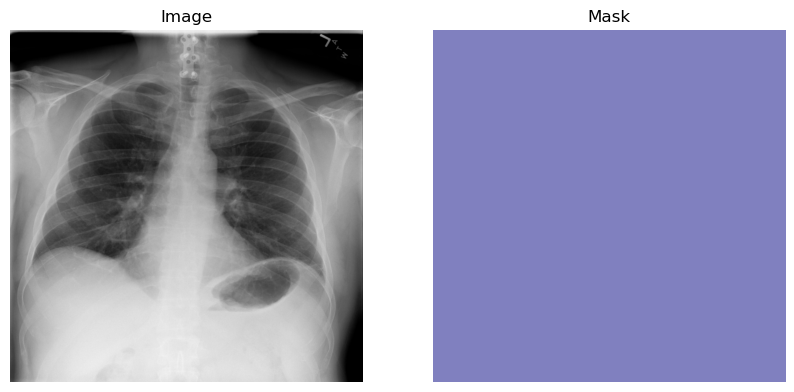

In [ ]:
batch_size = 16
img_size = 768

# Initialize the generator
train_generator = BatchGenerator("Data/train.csv", batch_size=batch_size, img_size=img_size, shuffle=True)

# Visualize a random image and its mask
visualize_random_image_and_mask(train_generator)

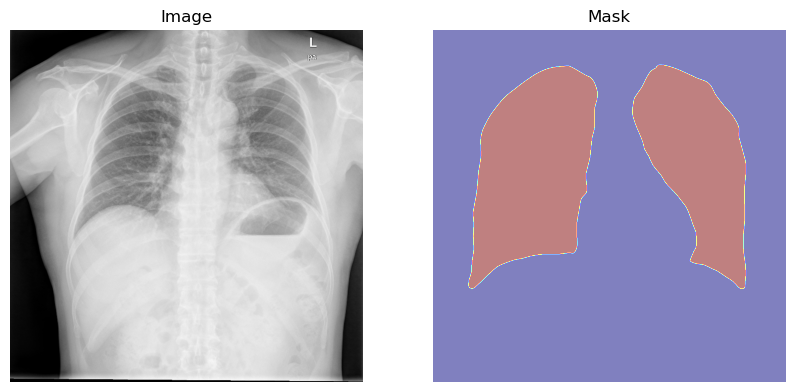

In [ ]:
# Initialize the generator
val_generator = BatchGenerator("Data/validation.csv", batch_size=batch_size, img_size=img_size, shuffle=True)

# Visualize a random image and its mask
visualize_random_image_and_mask(val_generator)

In [3]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Lambda, RepeatVector, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, Dropout, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization as bn
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import LeakyReLU,Add,ZeroPadding2D
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import callbacks


from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.activations import sigmoid

def attach_attention_module(net, attention_module):
    if attention_module == 'se_block': # SE_block
        net = se_block(net)
    elif attention_module == 'cbam_block': # CBAM_block
        net = cbam_block(net)
    else:
        raise Exception("'{}' is not supported attention module!".format(attention_module))

    return net

def se_block(input_feature, ratio=8):

	channel_axis = 1 if K.image_data_format() == "channels_first" else -1
	channel = input_feature.shape[channel_axis]

	se_feature = GlobalAveragePooling2D()(input_feature)
	se_feature = Reshape((1, 1, channel))(se_feature)
	assert se_feature.shape[1:] == (1,1,channel)
	se_feature = Dense(channel // ratio,
					   activation='relu',
					   kernel_initializer='he_normal',
					   use_bias=True,
					   bias_initializer='zeros')(se_feature)
	assert se_feature.shape[1:] == (1,1,channel//ratio)
	se_feature = Dense(channel,
					   activation='sigmoid',
					   kernel_initializer='he_normal',
					   use_bias=True,
					   bias_initializer='zeros')(se_feature)
	assert se_feature.shape[1:] == (1,1,channel)
	if K.image_data_format() == 'channels_first':
		se_feature = Permute((3, 1, 2))(se_feature)

	se_feature = multiply([input_feature, se_feature])
	return se_feature

def cbam_block(cbam_feature, ratio=8):

	cbam_feature = channel_attention(cbam_feature, ratio)
	cbam_feature = spatial_attention(cbam_feature)
	return cbam_feature

def channel_attention(input_feature, ratio=8):

	channel_axis = 1 if K.image_data_format() == "channels_first" else -1
	channel = input_feature.shape[channel_axis]

	shared_layer_one = Dense(channel//ratio,
							 activation='relu',
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	shared_layer_two = Dense(channel,
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')

	avg_pool = GlobalAveragePooling2D()(input_feature)
	avg_pool = Reshape((1,1,channel))(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)
	avg_pool = shared_layer_one(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel//ratio)
	avg_pool = shared_layer_two(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)

	max_pool = GlobalMaxPooling2D()(input_feature)
	max_pool = Reshape((1,1,channel))(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)
	max_pool = shared_layer_one(max_pool)
	assert max_pool.shape[1:] == (1,1,channel//ratio)
	max_pool = shared_layer_two(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)

	cbam_feature = Add()([avg_pool,max_pool])
	cbam_feature = Activation('sigmoid')(cbam_feature)

	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)

	return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
	kernel_size = 7

	if K.image_data_format() == "channels_first":
		channel = input_feature.shape[1]
		cbam_feature = Permute((2,3,1))(input_feature)
	else:
		channel = input_feature.shape[-1]
		cbam_feature = input_feature

	avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
	assert avg_pool.shape[-1] == 1
	max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
	assert max_pool.shape[-1] == 1
	concat = Concatenate(axis=3)([avg_pool, max_pool])
	assert concat.shape[-1] == 2
	cbam_feature = Conv2D(filters = 1,
					kernel_size=kernel_size,
					strides=1,
					padding='same',
					activation='sigmoid',
					kernel_initializer='he_normal',
					use_bias=False)(concat)
	assert cbam_feature.shape[-1] == 1

	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)

	return multiply([input_feature, cbam_feature])



def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    #x = attach_attention_module(x,attention_module='cbam_block')
    if activation == True:
        x = LeakyReLU(alpha=0.1)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = LeakyReLU(alpha=0.1)(blockInput)
    x = BatchNormalization()(x)
    x = attach_attention_module(x,attention_module='cbam_block')
    blockInput = BatchNormalization()(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    #x = attach_attention_module(x,attention_module='cbam_block')
    return x

def UXception(input_shape=(None, None, 3),dropout_rate=0.5):

    backbone = Xception(input_shape=input_shape,weights='imagenet',include_top=False)
    input = backbone.input
    start_neurons = 16

    conv4 = backbone.layers[121].output
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(dropout_rate)(pool4)

     # Middle
    convm = Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 32)
    convm = residual_block(convm,start_neurons * 32)
    convm = LeakyReLU(alpha=0.1)(convm)

    deconv4 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(dropout_rate)(uconv4)

    uconv4 = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = LeakyReLU(alpha=0.1)(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
    conv3 = backbone.layers[31].output
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(dropout_rate)(uconv3)

    uconv3 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = LeakyReLU(alpha=0.1)(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
    conv2 = backbone.layers[21].output
    conv2 = ZeroPadding2D(((1,0),(1,0)))(conv2)
    uconv2 = concatenate([deconv2, conv2])

    uconv2 = Dropout(0.1)(uconv2)
    uconv2 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = LeakyReLU(alpha=0.1)(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
    conv1 = backbone.layers[11].output
    conv1 = ZeroPadding2D(((3,0),(3,0)))(conv1)
    uconv1 = concatenate([deconv1, conv1])

    uconv1 = Dropout(0.1)(uconv1)
    uconv1 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = LeakyReLU(alpha=0.1)(uconv1)

    uconv0 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)
    uconv0 = Dropout(dropout_rate)(uconv0)
    uconv0 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
    uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = LeakyReLU(alpha=0.1)(uconv0)

    uconv0 = Dropout(dropout_rate/2)(uconv0)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv0)

    model = Model(input, output_layer)

    return model

In [4]:
img_size = 768
model = UXception(input_shape=(img_size, img_size, 3), dropout_rate = 0.3)
model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 768, 768, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 383, 383, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 383, 383, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 383, 383, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 381, 381, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 381, 381, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 381, 381, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 381, 381, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 381, 381, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 381, 381, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 381, 381, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 381, 381, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 191, 191, 128)  │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 191, 191, 128)  │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 38,609,613 (147.28 MB)

 Trainable params: 38,548,173 (147.05 MB)

 Non-trainable params: 61,440 (240.00 KB)

In [14]:
import tensorflow as tf

#------------------------------------------  weighted binary cross entropy ------------------------------------------
# to decrease the number of false negatives, set beta > 1
# to decrease the number of false positives, set beta < 1
def weighted_bce(y_true, y_pred):
    weights = (y_true * 10.) + 1.
    bce = K.binary_crossentropy(y_true, y_pred)
    weighted_bce = K.mean(bce * weights)
    return weighted_bce

#----------------------------------------------------  dice loss ---------------------------------------------------
def dice_loss(y_true, y_pred):
    smooth = 0.001
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

#----------------------------------------------------  dice coef ---------------------------------------------------
def dice_coef(y_true, y_pred):
    epsilon = 0.00001
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f)+epsilon)
    return score

#---------------------------------------------------- lr scheduler ---------------------------------------------------
def scheduler(epoch, lr):

    new_lr = lr

    if epoch == 9:
        new_lr = lr / 3

    return new_lr

#---------------------------------------------------------- adam -----------------------------------------------------
adam = Adam(learning_rate=1e-4)

In [8]:
model.compile(loss = weighted_bce, optimizer = adam, metrics = [dice_coef, "acc"])

In [ ]:
import os
from keras.callbacks import ModelCheckpoint, Callback, LearningRateScheduler
from keras.callbacks import ModelCheckpoint

file_name = 'TB_model'

model_checkpoint = ModelCheckpoint(file_name + '.hdf5',
                                   monitor = 'val_loss',
                                   mode = 'min',
                                   save_best_only = True,
                                   verbose = 1)

callbacks = [LearningRateScheduler(scheduler, verbose = 1), model_checkpoint]

In [ ]:
model.fit(train_generator,
          validation_data = val_generator,
          epochs = 12,
          verbose = 1,
          callbacks = callbacks,
          steps_per_epoch = len(train_generator),
          shuffle = True)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 6112 steps, validate for 1528 steps

Epoch 00001: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/12
  32/6112 [..............................] - ETA: 3:01:00 - loss: 0.7037 - dice_coef: 0.0191 - acc: 0.7647

MODEL TESTING

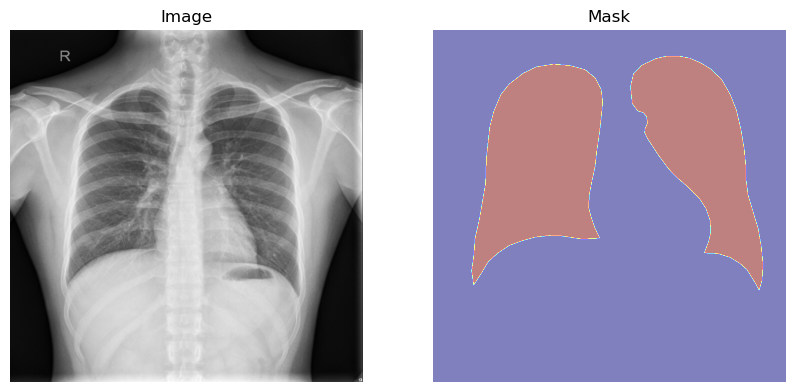

In [12]:
batch_size = 16
img_size = 768

# Initialize the generator
test_generator = BatchGenerator("Data/test.csv", batch_size=batch_size, img_size=img_size, shuffle=True)

# Visualize a random image and its mask
visualize_random_image_and_mask(test_generator)

In [ ]:
from tensorflow.keras.models import load_model
from keras.optimizers import Adam
from keras import backend as K

model = load_model('TB_model.hdf5',
                   custom_objects = {"weighted_bce": weighted_bce,
                                     "dice_coef": dice_coef})

model.summary()

Using TensorFlow backend.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 768, 768, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 383, 383, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 383, 383, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 383, 383, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [ ]:
test_preds = model.predict(test_generator, verbose = 1)

1610/1610 [==============================] - 208s 129ms/step


In [ ]:
import numpy as np

test_preds = np.squeeze(test_preds)

test_preds.shape

(1610, 768, 768)

mask dtype:  float32
mask shape:  (768, 768)
mask min, max:  5.0110695e-05 0.8979412


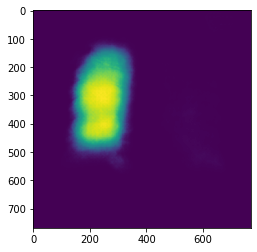

In [ ]:
import matplotlib.pyplot as plt

mask_num = 50

print("mask dtype: ", test_preds[mask_num].dtype)
print("mask shape: ", test_preds[mask_num].shape)
print("mask min, max: ", test_preds[mask_num].min(), test_preds[mask_num].max())

plt.imshow(test_preds[mask_num])#, cmap = 'gray')

In [ ]:
threshold = 0.5

pred_labels = []
num_of_positive_preds = 0
num_of_negative_preds = 0

for mask in test_preds:

    if mask.max() >= threshold:
        pred_labels.append(1)
        num_of_positive_preds = num_of_positive_preds + 1
    else:
        pred_labels.append(0)
        num_of_negative_preds = num_of_negative_preds + 1

print('Number of positive preds = ', num_of_positive_preds)
print('Number of negative preds = ', num_of_negative_preds)

Number of positive preds =  789
Number of negative preds =  821


In [ ]:
true_labels = []

for i in range(len(test_generator)):

    if test_generator[i][1][0].max() >= threshold:
        true_labels.append(1)
    else:
        true_labels.append(0)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

print('Confusion matirx')
print(confusion_matrix(true_labels, pred_labels))
print('')

print('classification report')
print(classification_report(true_labels, pred_labels))
print('')

print('ROC AUC score')
print(roc_auc_score(true_labels, pred_labels))
print('')

Confusion matirx
[[817 705]
 [  4  84]]

classification report
              precision    recall  f1-score   support

           0       1.00      0.54      0.70      1522
           1       0.11      0.95      0.19        88

    accuracy                           0.56      1610
   macro avg       0.55      0.75      0.44      1610
weighted avg       0.95      0.56      0.67      1610


ROC AUC score
0.7456695735276552

